# Import Modules

In [ ]:
import os
import numpy as np
from glob import glob
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet_v2 import preprocess_input, ResNet50V2

/home/aivn24/Khoa/tensorflow_venv/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [ ]:
np.random.seed(99)

# Balanced Data 

## Config and Load Data

In [ ]:
BATCH_SIZE = 512
IMG_HEGIHT  = 128
IMG_WIDHT   = 128
IMG_CHANNEL = 3
BUFFER_SIZE = BATCH_SIZE*10
MODEL_PATH = "/media/aivn24/partition2/Khoa/AI2021/imbalanced_classification/Exercise/gender_classification_models"
TRAIN_PATH = "/media/aivn24/partition2/Khoa/AI2021/imbalanced_classification/Exercise/gender-classification-dataset/train"
VAL_PATH = "/media/aivn24/partition2/Khoa/AI2021/imbalanced_classification/Exercise/gender-classification-dataset/val"
# CC_PATH = "/media/aivn24/partition2/Khoa/AI2021/imbalanced_classification/Exercise/gender-classification-dataset/cc"
CLASS_DICT = {
    'female':1,
    'male':0
}
rot_layer = tf.keras.layers.experimental.preprocessing.RandomRotation(0.1)

In [ ]:
def load(image_path, label):
    
    image   = tf.io.read_file(image_path)
    image   = tf.image.decode_jpeg(image, channels=IMG_CHANNEL)
    
    image  = tf.image.resize(image, (IMG_HEGIHT, IMG_WIDHT))
    
    # Convert both images to float32 tensors
    image  = tf.cast(image, tf.float32)
    
    return image, label

(128, 128, 3)


2022-03-27 11:29:44.039852: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-27 11:29:44.044856: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-27 11:29:44.045578: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-27 11:29:44.046714: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

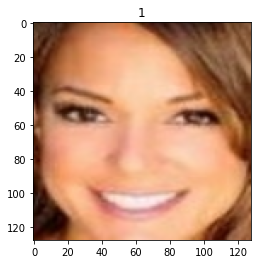

In [ ]:
test_image, label = load(os.path.join(TRAIN_PATH, "female/132220.jpg.jpg"), CLASS_DICT['female'])
print(test_image.shape)


# casting to int for matplotlib to show the image
plt.figure()
plt.title(label)
plt.imshow(test_image/255.0)

In [ ]:
@tf.function()
def random_flip(image):
    if tf.random.uniform(()) > 0.5:
        # Random mirroring
        image  = tf.image.flip_left_right(image)

#     image = tf.keras.preprocessing.image.random_rotation(image, rg=(-20, 20))
    image = rot_layer(image)
    return image


def processing_image(image):    
    image  =  preprocess_input(image) 
    return image


def load_image_train(image, label):
    image, label = load(image, label)
    image = random_flip(image)
    image = processing_image(image)

    return image, label


def load_image_val(image, label):
    image, label = load(image, label)
    image = processing_image(image)

    return image, label

In [ ]:
def get_img_path_and_labels(path, num_pos, num_neg=-1):
    pos_paths = np.array(glob(path + f'/{list(CLASS_DICT.keys())[0]}/*.jpg'))
    neg_paths = np.array(glob(path + f'/{list(CLASS_DICT.keys())[1]}/*.jpg'))
    
    assert (num_pos >= -1), f'Incorrect num_pos {num_pos}'
    assert (num_neg >= -1), f'Incorrect num_neg {num_neg}'
    if num_pos != -1:
        pos_paths = pos_paths[:num_pos]
    if num_neg != -1:
        neg_paths = neg_paths[:num_neg]
    image_paths = np.append(pos_paths, neg_paths)
    labels = np.array([CLASS_DICT[os.path.basename(os.path.dirname(im_p))] for im_p in image_paths])    
        
    print("TOTAL SAMPLES: ", len(image_paths))
    print('POSSITVE CLASS: ', sum(np.array(labels)==1))
    print('NEGATIVE CLASS: ', sum(np.array(labels)==0))
    idx = np.arange(len(labels))
    np.random.shuffle(idx)
    return image_paths[idx], labels[idx]

In [ ]:
train_imgs_path = get_img_path_and_labels(TRAIN_PATH, num_pos=-1)
train_dataset = tf.data.Dataset.from_tensor_slices((train_imgs_path[0], train_imgs_path[1]))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

TOTAL SAMPLES:  46000
POSSITVE CLASS:  23000
NEGATIVE CLASS:  23000


In [ ]:
val_imgs_path = get_img_path_and_labels(VAL_PATH, num_pos=-1)
val_dataset = tf.data.Dataset.from_tensor_slices((val_imgs_path[0],val_imgs_path[1]))
val_dataset = val_dataset.map(load_image_val)
val_dataset = val_dataset.batch(BATCH_SIZE)

TOTAL SAMPLES:  11600
POSSITVE CLASS:  5800
NEGATIVE CLASS:  5800


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


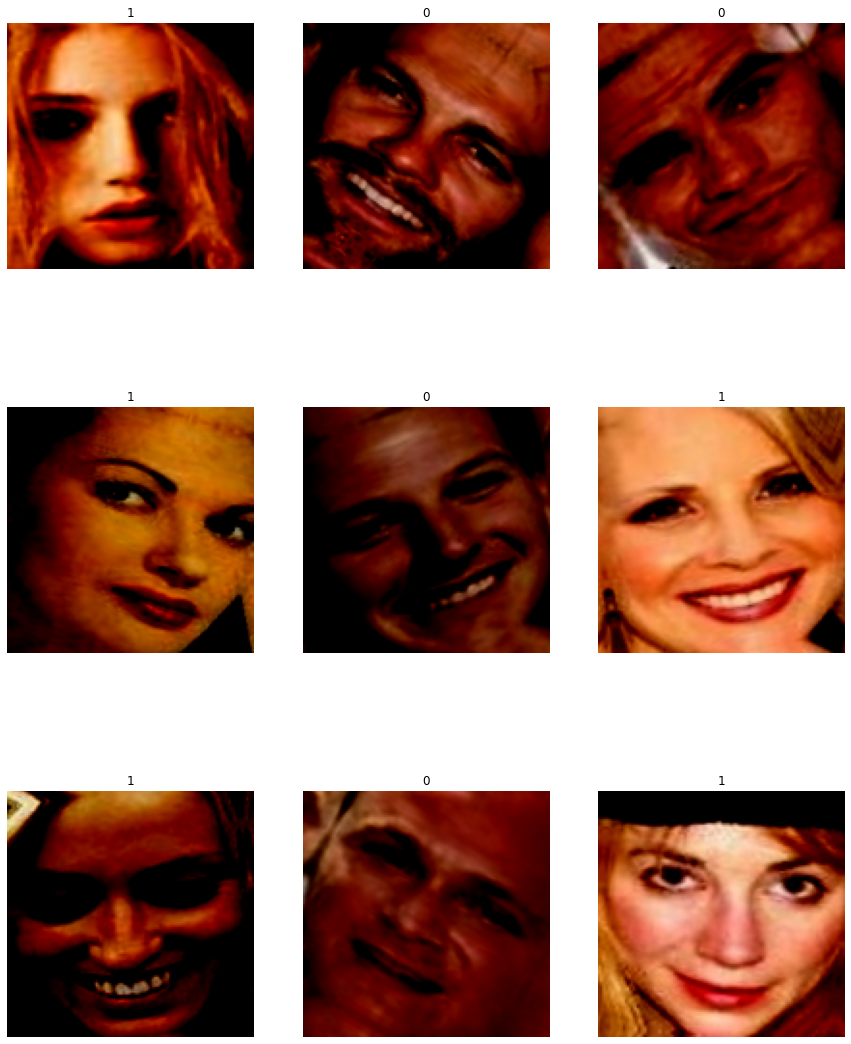

In [ ]:
for ims, las in train_dataset.take(1):
    plt.figure(figsize=(15,20))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.title(las[i].numpy())
        plt.imshow(ims[i])
        plt.axis('off')
    plt.show() 

## Build Model 

In [ ]:
def build_model(input_shape, final_act=None, weights=None):
    # Create the base model from the pre-trained model MobileNet V2
    base_model = ResNet50V2(input_shape=input_shape,
                                         include_top=False,
                                          weights=weights)
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    if final_act is not None:
        prediction_layer = tf.keras.layers.Dense(1, activation=final_act)
    else:
        prediction_layer = tf.keras.layers.Dense(1)
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs)
    x = global_average_layer(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [ ]:
balanced_model = build_model(input_shape= (IMG_HEGIHT, IMG_WIDHT, IMG_CHANNEL))

## Compile and Train 

In [ ]:
base_learning_rate = 0.0001
balanced_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(base_learning_rate),
              metrics=['accuracy'])

In [ ]:
balanced_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 23,521,409
Non-trainable params: 45,440
_________________________________________________________________


In [ ]:
len(balanced_model.trainable_variables)

174

In [ ]:
balanced_model_history = balanced_model.fit(train_dataset,
                         epochs=50,
                         validation_data=val_dataset)

Epoch 1/50


2022-03-23 00:28:28.878609: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-03-23 00:28:30.769134: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


90/90 [==============================] - 47s 453ms/step - loss: 0.5190 - accuracy: 0.7196 - val_loss: 1.6649 - val_accuracy: 0.5000
Epoch 2/50
90/90 [==============================] - 37s 405ms/step - loss: 0.3094 - accuracy: 0.8626 - val_loss: 1.4658 - val_accuracy: 0.5000
Epoch 3/50
90/90 [==============================] - 37s 407ms/step - loss: 0.2341 - accuracy: 0.9030 - val_loss: 0.6653 - val_accuracy: 0.6409
Epoch 4/50
90/90 [==============================] - 37s 407ms/step - loss: 0.1969 - accuracy: 0.9204 - val_loss: 0.3086 - val_accuracy: 0.8734
Epoch 5/50
90/90 [==============================] - 37s 407ms/step - loss: 0.1728 - accuracy: 0.9307 - val_loss: 0.2862 - val_accuracy: 0.9046
Epoch 6/50
90/90 [==============================] - 37s 408ms/step - loss: 0.1578 - accuracy: 0.9374 - val_loss: 0.1904 - val_accuracy: 0.9353
Epoch 7/50
90/90 [==============================] - 37s 408ms/step - loss: 0.1484 - accuracy: 0.9420 - val_loss: 0.1678 - val_accuracy: 0.9205
Epoch 8/50

In [ ]:
balanced_model.save(os.path.join(MODEL_PATH, 'balanced_model.h5'))

## Evaluate Models 

In [ ]:
def show_results(history, name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'Training and Validation Accuracy {name}')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'Training and Validation Loss {name}')
    plt.xlabel('epoch')
    plt.show()

In [ ]:
def get_correct_results(model, dataset):
    total_correct_pos = 0
    total_correct_neg = 0
    total_correct = 0

    for x,y in dataset:    
        y = tf.dtypes.cast(y, tf.int32)
        output = model.predict(x)

        prediction = output > 0.5   
        prediction = tf.dtypes.cast(prediction, tf.int32)

        correct_pre = prediction[:,0] == y
        correct_pre = tf.dtypes.cast(correct_pre, tf.int32)

        # accumulate
        total_correct = total_correct + tf.math.reduce_sum(correct_pre)
        total_correct_pos = total_correct_pos + tf.math.reduce_sum(correct_pre[y==1])
        total_correct_neg = total_correct_neg + tf.math.reduce_sum(correct_pre[y==0])

    print('total_correct: ', total_correct)
    print('total_correct_pos: ', total_correct_pos)
    print('total_correct_neg: ', total_correct_neg)

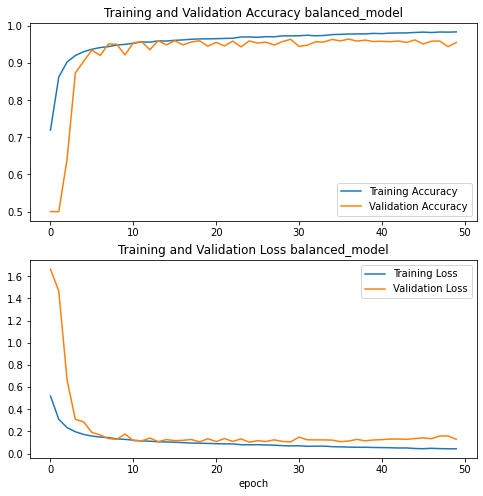

In [ ]:
show_results(balanced_model_history, name='balanced_model')

In [ ]:
get_correct_results(balanced_model, val_dataset)

total_correct:  tf.Tensor(11083, shape=(), dtype=int32)
total_correct_pos:  tf.Tensor(5467, shape=(), dtype=int32)
total_correct_neg:  tf.Tensor(5616, shape=(), dtype=int32)


# Imbalanced Data (2300 positive samples)

## Config and Load Data

In [ ]:
train_imgs_path = get_img_path_and_labels(TRAIN_PATH, num_pos=2300)
train_dataset = tf.data.Dataset.from_tensor_slices((train_imgs_path[0], train_imgs_path[1]))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

TOTAL SAMPLES:  25300
POSSITVE CLASS:  2300
NEGATIVE CLASS:  23000


In [ ]:
val_imgs_path = get_img_path_and_labels(VAL_PATH, num_pos=-1)
val_dataset = tf.data.Dataset.from_tensor_slices((val_imgs_path[0],val_imgs_path[1]))
val_dataset = val_dataset.map(load_image_val)
val_dataset = val_dataset.batch(BATCH_SIZE)

TOTAL SAMPLES:  11600
POSSITVE CLASS:  5800
NEGATIVE CLASS:  5800


## Build Model 

In [ ]:
imb2k3_model = build_model(input_shape= (IMG_HEGIHT, IMG_WIDHT, IMG_CHANNEL), final_act='sigmoid')

## Compile and Train 

In [ ]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


In [ ]:
base_learning_rate = 0.0001
imb2k3_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.Adam(base_learning_rate),
              metrics=METRICS)

In [ ]:
imb2k3_model_history = imb2k3_model.fit(train_dataset,
                         epochs=50,
                         validation_data=val_dataset)

Epoch 1/50
50/50 [==============================] - 26s 473ms/step - loss: 0.3703 - tp: 183.0000 - fp: 1464.0000 - tn: 21536.0000 - fn: 2117.0000 - accuracy: 0.8585 - precision: 0.1111 - recall: 0.0796 - auc: 0.6028 - prc: 0.1134 - val_loss: 0.9626 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5800.0000 - val_fn: 5800.0000 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5941 - val_prc: 0.5750
Epoch 2/50
50/50 [==============================] - 23s 461ms/step - loss: 0.2493 - tp: 192.0000 - fp: 94.0000 - tn: 22906.0000 - fn: 2108.0000 - accuracy: 0.9130 - precision: 0.6713 - recall: 0.0835 - auc: 0.8027 - prc: 0.3559 - val_loss: 1.9460 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5800.0000 - val_fn: 5800.0000 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5261 - val_prc: 0.5088
Epoch 3/50
50/50 [==============================] - 23s 456ms/step - loss: 0.1879 - tp: 910.0000 - fp: 340.0000 - tn

Epoch 20/50
50/50 [==============================] - 25s 485ms/step - loss: 0.0542 - tp: 1981.0000 - fp: 168.0000 - tn: 22832.0000 - fn: 319.0000 - accuracy: 0.9808 - precision: 0.9218 - recall: 0.8613 - auc: 0.9912 - prc: 0.9547 - val_loss: 0.3289 - val_tp: 4674.0000 - val_fp: 83.0000 - val_tn: 5717.0000 - val_fn: 1126.0000 - val_accuracy: 0.8958 - val_precision: 0.9826 - val_recall: 0.8059 - val_auc: 0.9744 - val_prc: 0.9789
Epoch 21/50
50/50 [==============================] - 25s 490ms/step - loss: 0.0578 - tp: 1983.0000 - fp: 215.0000 - tn: 22785.0000 - fn: 317.0000 - accuracy: 0.9790 - precision: 0.9022 - recall: 0.8622 - auc: 0.9907 - prc: 0.9496 - val_loss: 0.3174 - val_tp: 4489.0000 - val_fp: 47.0000 - val_tn: 5753.0000 - val_fn: 1311.0000 - val_accuracy: 0.8829 - val_precision: 0.9896 - val_recall: 0.7740 - val_auc: 0.9820 - val_prc: 0.9847
Epoch 22/50
50/50 [==============================] - 25s 488ms/step - loss: 0.0511 - tp: 1990.0000 - fp: 166.0000 - tn: 22834.0000 - fn: 3

50/50 [==============================] - 25s 494ms/step - loss: 0.0269 - tp: 2178.0000 - fp: 109.0000 - tn: 22891.0000 - fn: 122.0000 - accuracy: 0.9909 - precision: 0.9523 - recall: 0.9470 - auc: 0.9977 - prc: 0.9866 - val_loss: 0.2411 - val_tp: 5074.0000 - val_fp: 113.0000 - val_tn: 5687.0000 - val_fn: 726.0000 - val_accuracy: 0.9277 - val_precision: 0.9782 - val_recall: 0.8748 - val_auc: 0.9799 - val_prc: 0.9835
Epoch 40/50
50/50 [==============================] - 25s 492ms/step - loss: 0.0289 - tp: 2141.0000 - fp: 92.0000 - tn: 22908.0000 - fn: 159.0000 - accuracy: 0.9901 - precision: 0.9588 - recall: 0.9309 - auc: 0.9973 - prc: 0.9843 - val_loss: 0.6068 - val_tp: 4089.0000 - val_fp: 25.0000 - val_tn: 5775.0000 - val_fn: 1711.0000 - val_accuracy: 0.8503 - val_precision: 0.9939 - val_recall: 0.7050 - val_auc: 0.9603 - val_prc: 0.9721
Epoch 41/50
50/50 [==============================] - 25s 495ms/step - loss: 0.0280 - tp: 2155.0000 - fp: 120.0000 - tn: 22880.0000 - fn: 145.0000 - acc

In [ ]:
imb2k3_model.save(os.path.join(MODEL_PATH, 'imb2k3_model.h5'))

## Evaluate Models 

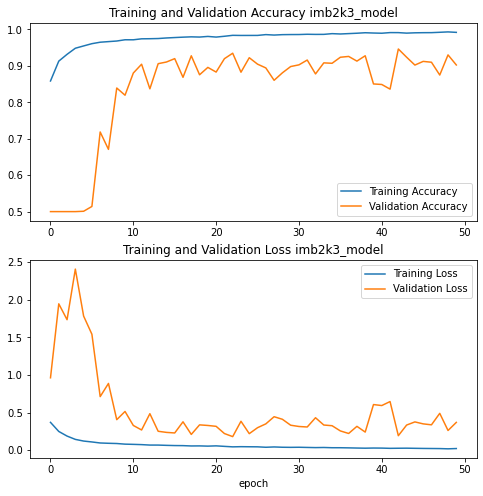

In [ ]:
show_results(imb2k3_model_history, name='imb2k3_model')

In [ ]:
get_correct_results(imb2k3_model, val_dataset)

total_correct:  tf.Tensor(10468, shape=(), dtype=int32)
total_correct_pos:  tf.Tensor(4738, shape=(), dtype=int32)
total_correct_neg:  tf.Tensor(5730, shape=(), dtype=int32)


# Imbalanced Data (1000 positive samples)

## Config and Load Data

In [ ]:
train_imgs_path = get_img_path_and_labels(TRAIN_PATH, num_pos=1000)
train_dataset = tf.data.Dataset.from_tensor_slices((train_imgs_path[0], train_imgs_path[1]))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

TOTAL SAMPLES:  24000
POSSITVE CLASS:  1000
NEGATIVE CLASS:  23000


In [ ]:
val_imgs_path = get_img_path_and_labels(VAL_PATH, num_pos=-1)
val_dataset = tf.data.Dataset.from_tensor_slices((val_imgs_path[0],val_imgs_path[1]))
val_dataset = val_dataset.map(load_image_val)
val_dataset = val_dataset.batch(BATCH_SIZE)

TOTAL SAMPLES:  11600
POSSITVE CLASS:  5800
NEGATIVE CLASS:  5800


## Build Model 

In [ ]:
imb1k_model = build_model(input_shape= (IMG_HEGIHT, IMG_WIDHT, IMG_CHANNEL), final_act='sigmoid')

## Compile and Train 

In [ ]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


In [ ]:
base_learning_rate = 0.0001
imb1k_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.Adam(base_learning_rate),
              metrics=METRICS)

In [ ]:
imb1k_model_history = imb1k_model.fit(train_dataset,
                         epochs=50,
                         validation_data=val_dataset)

Epoch 1/50
47/47 [==============================] - 25s 486ms/step - loss: 0.2861 - tp: 70.0000 - fp: 1571.0000 - tn: 21429.0000 - fn: 930.0000 - accuracy: 0.8958 - precision: 0.0427 - recall: 0.0700 - auc: 0.5591 - prc: 0.0463 - val_loss: 0.8880 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5800.0000 - val_fn: 5800.0000 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5473 - val_prc: 0.5367
Epoch 2/50
47/47 [==============================] - 23s 473ms/step - loss: 0.1584 - tp: 0.0000e+00 - fp: 2.0000 - tn: 22998.0000 - fn: 1000.0000 - accuracy: 0.9582 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7416 - prc: 0.1275 - val_loss: 1.5717 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5800.0000 - val_fn: 5800.0000 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5235 - val_prc: 0.5187
Epoch 3/50
47/47 [==============================] - 23s 490ms/step - loss: 0.1369 - tp: 49.0000 - fp: 17.0000

Epoch 20/50
47/47 [==============================] - 24s 493ms/step - loss: 0.0402 - tp: 772.0000 - fp: 107.0000 - tn: 22893.0000 - fn: 228.0000 - accuracy: 0.9860 - precision: 0.8783 - recall: 0.7720 - auc: 0.9867 - prc: 0.8988 - val_loss: 0.5091 - val_tp: 4265.0000 - val_fp: 78.0000 - val_tn: 5722.0000 - val_fn: 1535.0000 - val_accuracy: 0.8609 - val_precision: 0.9820 - val_recall: 0.7353 - val_auc: 0.9633 - val_prc: 0.9715
Epoch 21/50
47/47 [==============================] - 24s 497ms/step - loss: 0.0367 - tp: 792.0000 - fp: 87.0000 - tn: 22913.0000 - fn: 208.0000 - accuracy: 0.9877 - precision: 0.9010 - recall: 0.7920 - auc: 0.9891 - prc: 0.9149 - val_loss: 0.3677 - val_tp: 4544.0000 - val_fp: 73.0000 - val_tn: 5727.0000 - val_fn: 1256.0000 - val_accuracy: 0.8854 - val_precision: 0.9842 - val_recall: 0.7834 - val_auc: 0.9731 - val_prc: 0.9790
Epoch 22/50
47/47 [==============================] - 24s 496ms/step - loss: 0.0367 - tp: 786.0000 - fp: 110.0000 - tn: 22890.0000 - fn: 214.0

In [ ]:
imb1k_model.save(os.path.join(MODEL_PATH, 'imb1k_model.h5'))

## Evaluate Models 

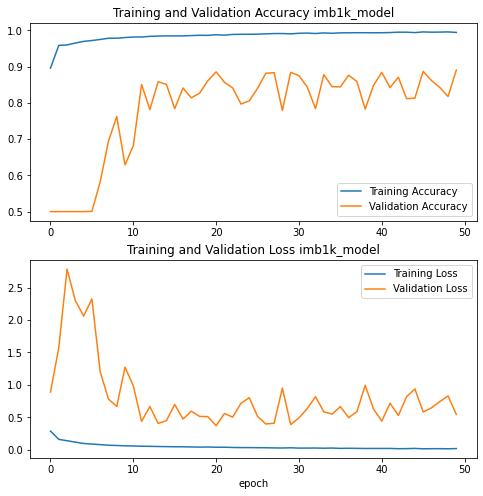

In [ ]:
show_results(imb1k_model_history, name='imb1k_model')

In [ ]:
get_correct_results(imb1k_model, val_dataset)

total_correct:  tf.Tensor(10329, shape=(), dtype=int32)
total_correct_pos:  tf.Tensor(4576, shape=(), dtype=int32)
total_correct_neg:  tf.Tensor(5753, shape=(), dtype=int32)


# Classweight Imbalanced Data (2300 positive samples)

## Config and Load Data

In [ ]:
train_imgs_path = get_img_path_and_labels(TRAIN_PATH, num_pos=2300)
train_dataset = tf.data.Dataset.from_tensor_slices((train_imgs_path[0], train_imgs_path[1]))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

TOTAL SAMPLES:  25300
POSSITVE CLASS:  2300
NEGATIVE CLASS:  23000


In [ ]:
val_imgs_path = get_img_path_and_labels(VAL_PATH, num_pos=-1)
val_dataset = tf.data.Dataset.from_tensor_slices((val_imgs_path[0],val_imgs_path[1]))
val_dataset = val_dataset.map(load_image_val)
val_dataset = val_dataset.batch(BATCH_SIZE)

TOTAL SAMPLES:  11600
POSSITVE CLASS:  5800
NEGATIVE CLASS:  5800


## Build Model 

In [ ]:
cw_ibm2k3_model = build_model(input_shape= (IMG_HEGIHT, IMG_WIDHT, IMG_CHANNEL), final_act='sigmoid')

## Compile and Train 

In [ ]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [ ]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
total = 2300 + 23000
weight_for_0 = (1 / 23000.0) * (total / 2.0)
weight_for_1 = (1 / 2300.0) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.55
Weight for class 1: 5.50


In [ ]:
base_learning_rate = 0.0001
cw_ibm2k3_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.Adam(base_learning_rate),
              metrics=METRICS)

In [ ]:
cw_ibm2k3_model_history = cw_ibm2k3_model.fit(train_dataset,
                         epochs=50,
                         validation_data=val_dataset,
                         class_weight=class_weight)

Epoch 1/50
50/50 [==============================] - 30s 548ms/step - loss: 0.6322 - tp: 1536.0000 - fp: 8469.0000 - tn: 14531.0000 - fn: 764.0000 - accuracy: 0.6351 - precision: 0.1535 - recall: 0.6678 - auc: 0.7083 - prc: 0.1972 - val_loss: 0.8372 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5800.0000 - val_fn: 5800.0000 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6143 - val_prc: 0.5917
Epoch 2/50
50/50 [==============================] - 31s 466ms/step - loss: 0.4878 - tp: 1804.0000 - fp: 5567.0000 - tn: 17433.0000 - fn: 496.0000 - accuracy: 0.7604 - precision: 0.2447 - recall: 0.7843 - auc: 0.8468 - prc: 0.4409 - val_loss: 1.9816 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5800.0000 - val_fn: 5800.0000 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6236 - val_prc: 0.6055
Epoch 3/50
50/50 [==============================] - 24s 472ms/step - loss: 0.4100 - tp: 1858.0000 - fp: 4369.0000 

Epoch 20/50
50/50 [==============================] - 24s 471ms/step - loss: 0.1190 - tp: 2208.0000 - fp: 1055.0000 - tn: 21945.0000 - fn: 92.0000 - accuracy: 0.9547 - precision: 0.6767 - recall: 0.9600 - auc: 0.9905 - prc: 0.9266 - val_loss: 0.1659 - val_tp: 5467.0000 - val_fp: 369.0000 - val_tn: 5431.0000 - val_fn: 333.0000 - val_accuracy: 0.9395 - val_precision: 0.9368 - val_recall: 0.9426 - val_auc: 0.9831 - val_prc: 0.9812
Epoch 21/50
50/50 [==============================] - 24s 469ms/step - loss: 0.1104 - tp: 2218.0000 - fp: 1026.0000 - tn: 21974.0000 - fn: 82.0000 - accuracy: 0.9562 - precision: 0.6837 - recall: 0.9643 - auc: 0.9915 - prc: 0.9261 - val_loss: 0.1765 - val_tp: 5266.0000 - val_fp: 239.0000 - val_tn: 5561.0000 - val_fn: 534.0000 - val_accuracy: 0.9334 - val_precision: 0.9566 - val_recall: 0.9079 - val_auc: 0.9829 - val_prc: 0.9833
Epoch 22/50
50/50 [==============================] - 24s 474ms/step - loss: 0.1121 - tp: 2218.0000 - fp: 1041.0000 - tn: 21959.0000 - fn: 

In [ ]:
cw_ibm2k3_model.save(os.path.join(MODEL_PATH, 'cw_ibm2k3_model.h5'))

## Evaluate Models 

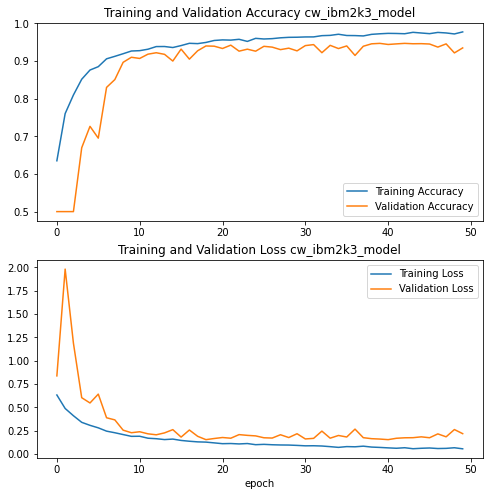

In [ ]:
show_results(cw_ibm2k3_model_history, name='cw_ibm2k3_model')

In [ ]:
get_correct_results(cw_ibm2k3_model, val_dataset)

total_correct:  tf.Tensor(10846, shape=(), dtype=int32)
total_correct_pos:  tf.Tensor(5211, shape=(), dtype=int32)
total_correct_neg:  tf.Tensor(5635, shape=(), dtype=int32)


# Classweight Imbalanced Data (1000 positive samples)

## Config and Load Data

In [ ]:
train_imgs_path = get_img_path_and_labels(TRAIN_PATH, num_pos=1000)
train_dataset = tf.data.Dataset.from_tensor_slices((train_imgs_path[0], train_imgs_path[1]))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

TOTAL SAMPLES:  24000
POSSITVE CLASS:  1000
NEGATIVE CLASS:  23000


In [ ]:
val_imgs_path = get_img_path_and_labels(VAL_PATH, num_pos=-1)
val_dataset = tf.data.Dataset.from_tensor_slices((val_imgs_path[0],val_imgs_path[1]))
val_dataset = val_dataset.map(load_image_val)
val_dataset = val_dataset.batch(BATCH_SIZE)

TOTAL SAMPLES:  11600
POSSITVE CLASS:  5800
NEGATIVE CLASS:  5800


## Build Model 

In [ ]:
cw_ibm1k_model = build_model(input_shape= (IMG_HEGIHT, IMG_WIDHT, IMG_CHANNEL), final_act='sigmoid')

## Compile and Train 

In [ ]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [ ]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
total = 1000 + 23000
weight_for_0 = (1 / 23000.0) * (total / 2.0)
weight_for_1 = (1 / 1000.0) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.52
Weight for class 1: 12.00


In [ ]:
base_learning_rate = 0.0001
cw_ibm1k_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.Adam(base_learning_rate),
              metrics=METRICS)

In [ ]:
cw_ibm1k_model_history = cw_ibm1k_model.fit(train_dataset,
                         epochs=50,
                         validation_data=val_dataset,
                         class_weight=class_weight)

Epoch 1/50
47/47 [==============================] - 27s 492ms/step - loss: 0.6461 - tp: 634.0000 - fp: 8243.0000 - tn: 14757.0000 - fn: 366.0000 - accuracy: 0.6413 - precision: 0.0714 - recall: 0.6340 - auc: 0.6922 - prc: 0.0918 - val_loss: 0.7486 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5800.0000 - val_fn: 5800.0000 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5281 - val_prc: 0.5114
Epoch 2/50
47/47 [==============================] - 23s 476ms/step - loss: 0.5442 - tp: 723.0000 - fp: 6461.0000 - tn: 16539.0000 - fn: 277.0000 - accuracy: 0.7193 - precision: 0.1006 - recall: 0.7230 - auc: 0.7984 - prc: 0.1963 - val_loss: 1.3456 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5800.0000 - val_fn: 5800.0000 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4855 - val_prc: 0.4830
Epoch 3/50
47/47 [==============================] - 23s 474ms/step - loss: 0.4915 - tp: 772.0000 - fp: 5545.0000 - t

Epoch 20/50
47/47 [==============================] - 23s 472ms/step - loss: 0.1320 - tp: 950.0000 - fp: 1296.0000 - tn: 21704.0000 - fn: 50.0000 - accuracy: 0.9439 - precision: 0.4230 - recall: 0.9500 - auc: 0.9890 - prc: 0.8336 - val_loss: 0.2414 - val_tp: 4938.0000 - val_fp: 208.0000 - val_tn: 5592.0000 - val_fn: 862.0000 - val_accuracy: 0.9078 - val_precision: 0.9596 - val_recall: 0.8514 - val_auc: 0.9757 - val_prc: 0.9765
Epoch 21/50
47/47 [==============================] - 23s 477ms/step - loss: 0.1160 - tp: 960.0000 - fp: 1238.0000 - tn: 21762.0000 - fn: 40.0000 - accuracy: 0.9467 - precision: 0.4368 - recall: 0.9600 - auc: 0.9910 - prc: 0.8288 - val_loss: 0.2229 - val_tp: 5052.0000 - val_fp: 221.0000 - val_tn: 5579.0000 - val_fn: 748.0000 - val_accuracy: 0.9165 - val_precision: 0.9581 - val_recall: 0.8710 - val_auc: 0.9769 - val_prc: 0.9778
Epoch 22/50
47/47 [==============================] - 23s 477ms/step - loss: 0.1270 - tp: 955.0000 - fp: 1176.0000 - tn: 21824.0000 - fn: 45.

In [ ]:
cw_ibm1k_model.save(os.path.join(MODEL_PATH, 'cw_ibm1k_model.h5'))

## Evaluate Models 

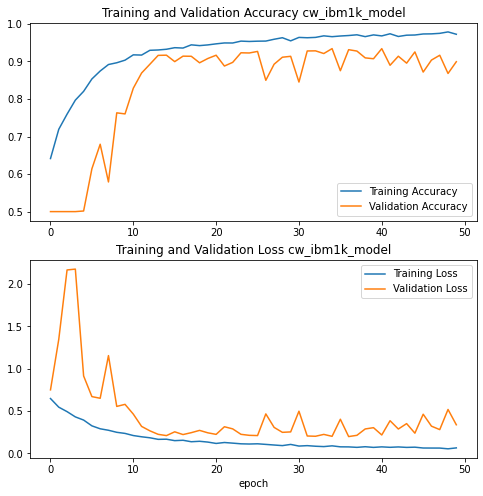

In [ ]:
show_results(cw_ibm1k_model_history, name='cw_ibm1k_model')

In [ ]:
get_correct_results(cw_ibm1k_model, val_dataset)

total_correct:  tf.Tensor(10429, shape=(), dtype=int32)
total_correct_pos:  tf.Tensor(4747, shape=(), dtype=int32)
total_correct_neg:  tf.Tensor(5682, shape=(), dtype=int32)


# Undersample Imbalanced Data (2300 positive samples) 

## Config and Load Data

In [ ]:
train_imgs_path = get_img_path_and_labels(TRAIN_PATH, num_pos=2300,  num_neg=2300)
train_dataset = tf.data.Dataset.from_tensor_slices((train_imgs_path[0], train_imgs_path[1]))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

TOTAL SAMPLES:  4600
POSSITVE CLASS:  2300
NEGATIVE CLASS:  2300


In [ ]:
val_imgs_path = get_img_path_and_labels(VAL_PATH, num_pos=-1)
val_dataset = tf.data.Dataset.from_tensor_slices((val_imgs_path[0],val_imgs_path[1]))
val_dataset = val_dataset.map(load_image_val)
val_dataset = val_dataset.batch(BATCH_SIZE)

TOTAL SAMPLES:  11600
POSSITVE CLASS:  5800
NEGATIVE CLASS:  5800


## Build Model 

In [ ]:
u_imb2k3_model = build_model(input_shape= (IMG_HEGIHT, IMG_WIDHT, IMG_CHANNEL))

## Compile and Train 

In [ ]:
base_learning_rate = 0.0001
u_imb2k3_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(base_learning_rate),
              metrics=['accuracy'])

In [ ]:
u_imb2k3_model_history = u_imb2k3_model.fit(train_dataset,
                         epochs=50,
                         validation_data=val_dataset)

Epoch 1/50
9/9 [==============================] - 11s 1s/step - loss: 0.6993 - accuracy: 0.5526 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 2/50
9/9 [==============================] - 6s 651ms/step - loss: 0.6270 - accuracy: 0.6113 - val_loss: 0.6970 - val_accuracy: 0.5000
Epoch 3/50
9/9 [==============================] - 6s 653ms/step - loss: 0.5973 - accuracy: 0.6354 - val_loss: 0.7139 - val_accuracy: 0.5000
Epoch 4/50
9/9 [==============================] - 6s 653ms/step - loss: 0.5447 - accuracy: 0.7102 - val_loss: 0.7298 - val_accuracy: 0.5000
Epoch 5/50
9/9 [==============================] - 6s 653ms/step - loss: 0.4989 - accuracy: 0.7489 - val_loss: 0.8260 - val_accuracy: 0.5000
Epoch 6/50
9/9 [==============================] - 6s 654ms/step - loss: 0.4641 - accuracy: 0.7720 - val_loss: 0.9461 - val_accuracy: 0.5000
Epoch 7/50
9/9 [==============================] - 6s 656ms/step - loss: 0.4193 - accuracy: 0.8002 - val_loss: 0.9616 - val_accuracy: 0.5000
Epoch 8/50
9/9 [======

In [ ]:
u_imb2k3_model.save(os.path.join(MODEL_PATH, 'u_imb2k3_model.h5'))

## Evaluate Models 

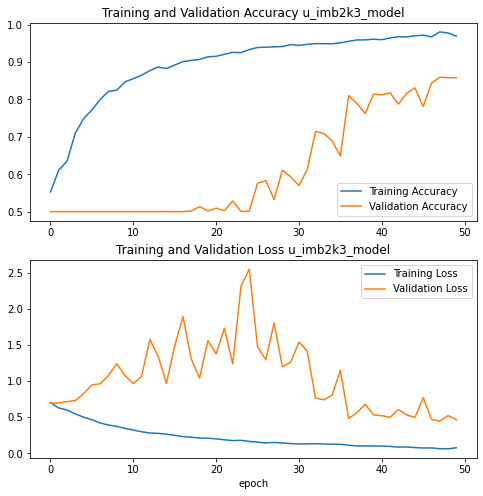

In [ ]:
show_results(u_imb2k3_model_history, name='u_imb2k3_model')

In [ ]:
get_correct_results(u_imb2k3_model, val_dataset)

total_correct:  tf.Tensor(9956, shape=(), dtype=int32)
total_correct_pos:  tf.Tensor(4463, shape=(), dtype=int32)
total_correct_neg:  tf.Tensor(5493, shape=(), dtype=int32)


# Undersample Imbalanced Data (1000 positive samples) 

## Config and Load Data

In [ ]:
train_imgs_path = get_img_path_and_labels(TRAIN_PATH, num_pos=1000,  num_neg=1000)
train_dataset = tf.data.Dataset.from_tensor_slices((train_imgs_path[0], train_imgs_path[1]))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

TOTAL SAMPLES:  2000
POSSITVE CLASS:  1000
NEGATIVE CLASS:  1000


In [ ]:
val_imgs_path = get_img_path_and_labels(VAL_PATH, num_pos=-1)
val_dataset = tf.data.Dataset.from_tensor_slices((val_imgs_path[0],val_imgs_path[1]))
val_dataset = val_dataset.map(load_image_val)
val_dataset = val_dataset.batch(BATCH_SIZE)

TOTAL SAMPLES:  11600
POSSITVE CLASS:  5800
NEGATIVE CLASS:  5800


## Build Model 

In [ ]:
u_imb1k_model = build_model(input_shape= (IMG_HEGIHT, IMG_WIDHT, IMG_CHANNEL))

## Compile and Train 

In [ ]:
base_learning_rate = 0.0001
u_imb1k_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(base_learning_rate),
              metrics=['accuracy'])

In [ ]:
u_imb1k_model_history = u_imb1k_model.fit(train_dataset,
                         epochs=50,
                         validation_data=val_dataset)

Epoch 1/50
4/4 [==============================] - 9s 2s/step - loss: 0.7578 - accuracy: 0.5245 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/50
4/4 [==============================] - 4s 1s/step - loss: 0.7368 - accuracy: 0.5800 - val_loss: 0.6938 - val_accuracy: 0.5000
Epoch 3/50
4/4 [==============================] - 4s 1s/step - loss: 0.6869 - accuracy: 0.5920 - val_loss: 0.6980 - val_accuracy: 0.5000
Epoch 4/50
4/4 [==============================] - 4s 1s/step - loss: 0.6313 - accuracy: 0.6020 - val_loss: 0.7014 - val_accuracy: 0.5000
Epoch 5/50
4/4 [==============================] - 4s 1s/step - loss: 0.6251 - accuracy: 0.6115 - val_loss: 0.7083 - val_accuracy: 0.5000
Epoch 6/50
4/4 [==============================] - 4s 1s/step - loss: 0.6013 - accuracy: 0.6240 - val_loss: 0.7214 - val_accuracy: 0.5000
Epoch 7/50
4/4 [==============================] - 4s 1s/step - loss: 0.5817 - accuracy: 0.6670 - val_loss: 0.7344 - val_accuracy: 0.5000
Epoch 8/50
4/4 [=========================

In [ ]:
u_imb1k_model.save(os.path.join(MODEL_PATH, 'u_imb1k_model.h5'))

## Evaluate Models 

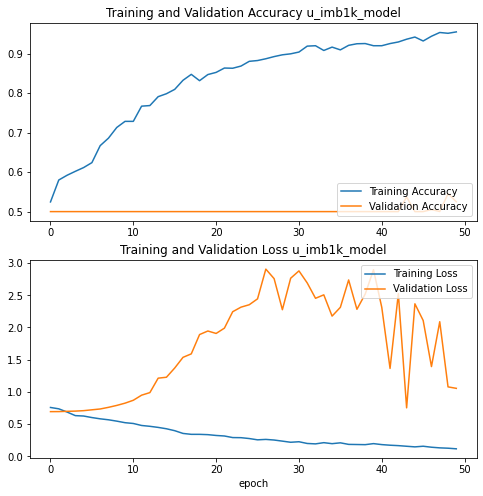

In [ ]:
show_results(u_imb1k_model_history, name='u_imb1k_model')

In [ ]:
get_correct_results(u_imb1k_model, val_dataset)

total_correct:  tf.Tensor(6089, shape=(), dtype=int32)
total_correct_pos:  tf.Tensor(323, shape=(), dtype=int32)
total_correct_neg:  tf.Tensor(5766, shape=(), dtype=int32)


# Focal Loss Imbalanced Data (2300 positive samples)

## Config and Load Data

In [ ]:
train_imgs_path = get_img_path_and_labels(TRAIN_PATH, num_pos=2300)
train_dataset = tf.data.Dataset.from_tensor_slices((train_imgs_path[0], train_imgs_path[1]))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

TOTAL SAMPLES:  25300
POSSITVE CLASS:  2300
NEGATIVE CLASS:  23000


In [ ]:
val_imgs_path = get_img_path_and_labels(VAL_PATH, num_pos=-1)
val_dataset = tf.data.Dataset.from_tensor_slices((val_imgs_path[0],val_imgs_path[1]))
val_dataset = val_dataset.map(load_image_val)
val_dataset = val_dataset.batch(BATCH_SIZE)

TOTAL SAMPLES:  11600
POSSITVE CLASS:  5800
NEGATIVE CLASS:  5800


## Build Model 

In [ ]:
fc_imb2k3_model = build_model(input_shape= (IMG_HEGIHT, IMG_WIDHT, IMG_CHANNEL), final_act='sigmoid')

## Compile and Train 

In [ ]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


In [ ]:
base_learning_rate = 0.0001
loss_func = tfa.losses.SigmoidFocalCrossEntropy()

fc_imb2k3_model.compile(loss=loss_func,
              optimizer = tf.keras.optimizers.Adam(base_learning_rate),
              metrics=METRICS)

In [ ]:
fc_imb2k3_model_history = fc_imb2k3_model.fit(train_dataset,
                         epochs=50,
                         validation_data=val_dataset)

Epoch 1/50
50/50 [==============================] - 27s 498ms/step - loss: 0.0357 - tp: 18.0000 - fp: 188.0000 - tn: 22812.0000 - fn: 2282.0000 - accuracy: 0.9024 - precision: 0.0874 - recall: 0.0078 - auc: 0.6274 - prc: 0.1298 - val_loss: 0.0974 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5800.0000 - val_fn: 5800.0000 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5815 - val_prc: 0.5607
Epoch 2/50
50/50 [==============================] - 25s 491ms/step - loss: 0.0246 - tp: 12.0000 - fp: 3.0000 - tn: 22997.0000 - fn: 2288.0000 - accuracy: 0.9094 - precision: 0.8000 - recall: 0.0052 - auc: 0.7939 - prc: 0.3312 - val_loss: 0.2373 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5800.0000 - val_fn: 5800.0000 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6148 - val_prc: 0.5773
Epoch 3/50
50/50 [==============================] - 24s 480ms/step - loss: 0.0218 - tp: 135.0000 - fp: 25.0000 - tn: 229

Epoch 20/50
50/50 [==============================] - 25s 484ms/step - loss: 0.0073 - tp: 1645.0000 - fp: 77.0000 - tn: 22923.0000 - fn: 655.0000 - accuracy: 0.9711 - precision: 0.9553 - recall: 0.7152 - auc: 0.9877 - prc: 0.9307 - val_loss: 0.0193 - val_tp: 4983.0000 - val_fp: 132.0000 - val_tn: 5668.0000 - val_fn: 817.0000 - val_accuracy: 0.9182 - val_precision: 0.9742 - val_recall: 0.8591 - val_auc: 0.9837 - val_prc: 0.9841
Epoch 21/50
50/50 [==============================] - 25s 486ms/step - loss: 0.0077 - tp: 1609.0000 - fp: 107.0000 - tn: 22893.0000 - fn: 691.0000 - accuracy: 0.9685 - precision: 0.9376 - recall: 0.6996 - auc: 0.9867 - prc: 0.9227 - val_loss: 0.0269 - val_tp: 4405.0000 - val_fp: 61.0000 - val_tn: 5739.0000 - val_fn: 1395.0000 - val_accuracy: 0.8745 - val_precision: 0.9863 - val_recall: 0.7595 - val_auc: 0.9821 - val_prc: 0.9828
Epoch 22/50
50/50 [==============================] - 25s 490ms/step - loss: 0.0070 - tp: 1688.0000 - fp: 86.0000 - tn: 22914.0000 - fn: 612

In [ ]:
fc_imb2k3_model.save(os.path.join(MODEL_PATH, 'fc_imb2k3_model.h5'))

## Evaluate Models 

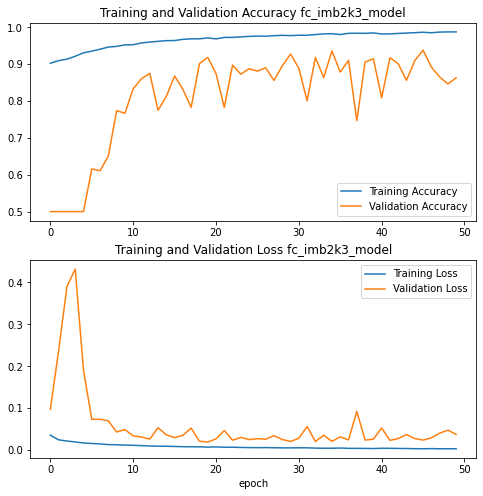

In [ ]:
show_results(fc_imb2k3_model_history, name='fc_imb2k3_model')

In [ ]:
get_correct_results(fc_imb2k3_model, val_dataset)

total_correct:  tf.Tensor(10010, shape=(), dtype=int32)
total_correct_pos:  tf.Tensor(4250, shape=(), dtype=int32)
total_correct_neg:  tf.Tensor(5760, shape=(), dtype=int32)


# Focal Loss Imbalanced Data (1000 positive samples)

## Config and Load Data

In [ ]:
train_imgs_path = get_img_path_and_labels(TRAIN_PATH, num_pos=1000)
train_dataset = tf.data.Dataset.from_tensor_slices((train_imgs_path[0], train_imgs_path[1]))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

TOTAL SAMPLES:  24000
POSSITVE CLASS:  1000
NEGATIVE CLASS:  23000


In [ ]:
val_imgs_path = get_img_path_and_labels(VAL_PATH, num_pos=-1)
val_dataset = tf.data.Dataset.from_tensor_slices((val_imgs_path[0],val_imgs_path[1]))
val_dataset = val_dataset.map(load_image_val)
val_dataset = val_dataset.batch(BATCH_SIZE)

TOTAL SAMPLES:  11600
POSSITVE CLASS:  5800
NEGATIVE CLASS:  5800


## Build Model 

In [ ]:
fc_imb1k_model = build_model(input_shape= (IMG_HEGIHT, IMG_WIDHT, IMG_CHANNEL), final_act='sigmoid')

## Compile and Train 

In [ ]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


In [ ]:
base_learning_rate = 0.0001
loss_func = tfa.losses.SigmoidFocalCrossEntropy()

fc_imb1k_model.compile(loss=loss_func,
              optimizer = tf.keras.optimizers.Adam(base_learning_rate),
              metrics=METRICS)

In [ ]:
fc_imb1k_model_history = fc_imb1k_model.fit(train_dataset,
                         epochs=50,
                         validation_data=val_dataset)

Epoch 1/50
47/47 [==============================] - 26s 512ms/step - loss: 0.0385 - tp: 53.0000 - fp: 1302.0000 - tn: 21698.0000 - fn: 947.0000 - accuracy: 0.9063 - precision: 0.0391 - recall: 0.0530 - auc: 0.5668 - prc: 0.0477 - val_loss: 0.0737 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5800.0000 - val_fn: 5800.0000 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5631 - val_prc: 0.5489
Epoch 2/50
47/47 [==============================] - 24s 495ms/step - loss: 0.0163 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 23000.0000 - fn: 1000.0000 - accuracy: 0.9583 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7111 - prc: 0.1081 - val_loss: 0.0992 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5800.0000 - val_fn: 5800.0000 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6246 - val_prc: 0.6010
Epoch 3/50
47/47 [==============================] - 24s 495ms/step - loss: 0.0142 - tp: 0.0000e+00 - fp: 

Epoch 20/50
47/47 [==============================] - 24s 493ms/step - loss: 0.0051 - tp: 585.0000 - fp: 38.0000 - tn: 22962.0000 - fn: 415.0000 - accuracy: 0.9811 - precision: 0.9390 - recall: 0.5850 - auc: 0.9839 - prc: 0.8577 - val_loss: 0.0644 - val_tp: 3467.0000 - val_fp: 31.0000 - val_tn: 5769.0000 - val_fn: 2333.0000 - val_accuracy: 0.7962 - val_precision: 0.9911 - val_recall: 0.5978 - val_auc: 0.9597 - val_prc: 0.9674
Epoch 21/50
47/47 [==============================] - 24s 500ms/step - loss: 0.0050 - tp: 586.0000 - fp: 46.0000 - tn: 22954.0000 - fn: 414.0000 - accuracy: 0.9808 - precision: 0.9272 - recall: 0.5860 - auc: 0.9856 - prc: 0.8567 - val_loss: 0.0754 - val_tp: 2665.0000 - val_fp: 2.0000 - val_tn: 5798.0000 - val_fn: 3135.0000 - val_accuracy: 0.7296 - val_precision: 0.9993 - val_recall: 0.4595 - val_auc: 0.9677 - val_prc: 0.9734
Epoch 22/50
47/47 [==============================] - 24s 498ms/step - loss: 0.0046 - tp: 607.0000 - fp: 38.0000 - tn: 22962.0000 - fn: 393.0000

In [ ]:
fc_imb1k_model.save(os.path.join(MODEL_PATH, 'fc_imb1k_model.h5'))

## Evaluate Models 

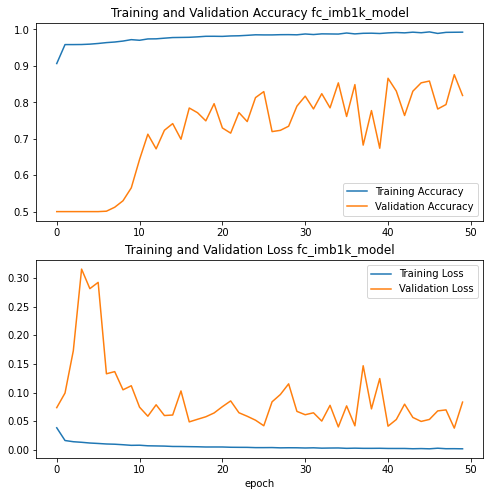

In [ ]:
show_results(fc_imb1k_model_history, name='fc_imb1k_model')

In [ ]:
get_correct_results(fc_imb1k_model, val_dataset)

total_correct:  tf.Tensor(9497, shape=(), dtype=int32)
total_correct_pos:  tf.Tensor(3717, shape=(), dtype=int32)
total_correct_neg:  tf.Tensor(5780, shape=(), dtype=int32)


# Oversample Imbalanced Data (2300 positive samples) 

## Config and Load Data

In [ ]:
TRAIN_PATH_OVER_2k3 = "/media/aivn24/partition2/Khoa/AI2021/imbalanced_classification/Exercise/over_data/2k3_augment"

In [ ]:
train_imgs_path = get_img_path_and_labels(TRAIN_PATH_OVER_2k3, num_pos=-1)
train_dataset = tf.data.Dataset.from_tensor_slices((train_imgs_path[0], train_imgs_path[1]))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

TOTAL SAMPLES:  46000
POSSITVE CLASS:  23000
NEGATIVE CLASS:  23000


In [ ]:
val_imgs_path = get_img_path_and_labels(VAL_PATH, num_pos=-1)
val_dataset = tf.data.Dataset.from_tensor_slices((val_imgs_path[0],val_imgs_path[1]))
val_dataset = val_dataset.map(load_image_val)
val_dataset = val_dataset.batch(BATCH_SIZE)

TOTAL SAMPLES:  11600
POSSITVE CLASS:  5800
NEGATIVE CLASS:  5800


## Build Model 

In [ ]:
o_imb2k3_model = build_model(input_shape= (IMG_HEGIHT, IMG_WIDHT, IMG_CHANNEL))

## Compile and Train 

In [ ]:
base_learning_rate = 0.0001
o_imb2k3_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(base_learning_rate),
              metrics=['accuracy'])

In [ ]:
o_imb2k3_model_history = o_imb2k3_model.fit(train_dataset,
                         epochs=50,
                         validation_data=val_dataset)

Epoch 1/50


2022-03-27 11:30:33.727697: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-03-27 11:30:35.650996: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


90/90 [==============================] - 120s 1s/step - loss: 0.4322 - accuracy: 0.7799 - val_loss: 1.7096 - val_accuracy: 0.5000
Epoch 2/50
90/90 [==============================] - 38s 416ms/step - loss: 0.2646 - accuracy: 0.8845 - val_loss: 3.3210 - val_accuracy: 0.5000
Epoch 3/50
90/90 [==============================] - 38s 417ms/step - loss: 0.1964 - accuracy: 0.9174 - val_loss: 1.5566 - val_accuracy: 0.5157
Epoch 4/50
90/90 [==============================] - 38s 418ms/step - loss: 0.1588 - accuracy: 0.9342 - val_loss: 0.4654 - val_accuracy: 0.7705
Epoch 5/50
90/90 [==============================] - 38s 419ms/step - loss: 0.1305 - accuracy: 0.9474 - val_loss: 0.4003 - val_accuracy: 0.8234
Epoch 6/50
90/90 [==============================] - 38s 419ms/step - loss: 0.1168 - accuracy: 0.9531 - val_loss: 0.2753 - val_accuracy: 0.8807
Epoch 7/50
90/90 [==============================] - 38s 419ms/step - loss: 0.1026 - accuracy: 0.9593 - val_loss: 0.2292 - val_accuracy: 0.9030
Epoch 8/50
9

In [ ]:
o_imb2k3_model.save(os.path.join(MODEL_PATH, 'o_imb2k3_model.h5'))

## Evaluate Models 

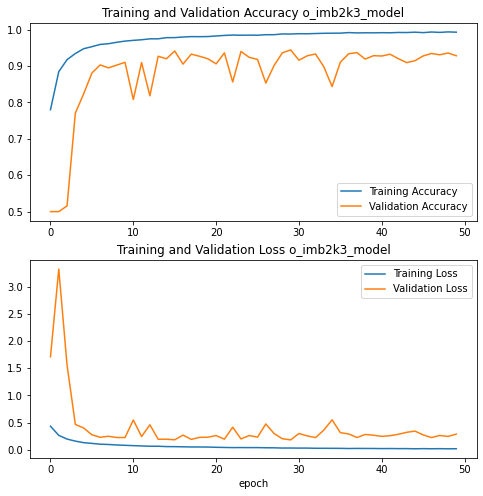

In [ ]:
show_results(o_imb2k3_model_history, name='o_imb2k3_model')

In [ ]:
get_correct_results(o_imb2k3_model, val_dataset)

total_correct:  tf.Tensor(10766, shape=(), dtype=int32)
total_correct_pos:  tf.Tensor(5095, shape=(), dtype=int32)
total_correct_neg:  tf.Tensor(5671, shape=(), dtype=int32)


# Oversample Imbalanced Data (1000 positive samples) 

## Config and Load Data

In [ ]:
TRAIN_PATH_OVER_1k = "/media/aivn24/partition2/Khoa/AI2021/imbalanced_classification/Exercise/over_data/1k_augment"

In [ ]:
train_imgs_path = get_img_path_and_labels(TRAIN_PATH_OVER_1k, num_pos=-1)
train_dataset = tf.data.Dataset.from_tensor_slices((train_imgs_path[0], train_imgs_path[1]))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

TOTAL SAMPLES:  46000
POSSITVE CLASS:  23000
NEGATIVE CLASS:  23000


In [ ]:
val_imgs_path = get_img_path_and_labels(VAL_PATH, num_pos=-1)
val_dataset = tf.data.Dataset.from_tensor_slices((val_imgs_path[0],val_imgs_path[1]))
val_dataset = val_dataset.map(load_image_val)
val_dataset = val_dataset.batch(BATCH_SIZE)

TOTAL SAMPLES:  11600
POSSITVE CLASS:  5800
NEGATIVE CLASS:  5800


## Build Model 

In [ ]:
o_imb1k_model = build_model(input_shape= (IMG_HEGIHT, IMG_WIDHT, IMG_CHANNEL))

## Compile and Train 

In [ ]:
base_learning_rate = 0.0001
o_imb1k_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(base_learning_rate),
              metrics=['accuracy'])

In [ ]:
o_imb1k_model_history = o_imb1k_model.fit(train_dataset,
                         epochs=50,
                         validation_data=val_dataset)

Epoch 1/50


2022-03-27 12:03:54.380849: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 4827 of 5120
2022-03-27 12:03:54.849177: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


90/90 [==============================] - 113s 1s/step - loss: 0.4159 - accuracy: 0.7887 - val_loss: 2.0033 - val_accuracy: 0.5000
Epoch 2/50
90/90 [==============================] - 37s 405ms/step - loss: 0.2376 - accuracy: 0.8942 - val_loss: 2.0383 - val_accuracy: 0.5000
Epoch 3/50
90/90 [==============================] - 37s 407ms/step - loss: 0.1740 - accuracy: 0.9262 - val_loss: 0.8022 - val_accuracy: 0.6220
Epoch 4/50
90/90 [==============================] - 37s 408ms/step - loss: 0.1390 - accuracy: 0.9423 - val_loss: 1.2472 - val_accuracy: 0.6029
Epoch 5/50
90/90 [==============================] - 37s 407ms/step - loss: 0.1173 - accuracy: 0.9523 - val_loss: 0.7781 - val_accuracy: 0.7116
Epoch 6/50
90/90 [==============================] - 37s 408ms/step - loss: 0.0983 - accuracy: 0.9612 - val_loss: 0.4941 - val_accuracy: 0.7990
Epoch 7/50
90/90 [==============================] - 37s 408ms/step - loss: 0.0878 - accuracy: 0.9651 - val_loss: 0.4396 - val_accuracy: 0.8384
Epoch 8/50
9

In [ ]:
o_imb1k_model.save(os.path.join(MODEL_PATH, 'o_imb1k_model.h5'))

## Evaluate Models 

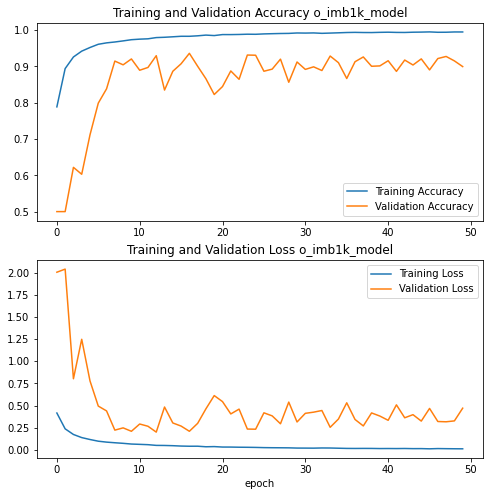

In [ ]:
show_results(o_imb1k_model_history, name='o_imb1k_model')

In [ ]:
get_correct_results(o_imb1k_model, val_dataset)

total_correct:  tf.Tensor(10437, shape=(), dtype=int32)
total_correct_pos:  tf.Tensor(4761, shape=(), dtype=int32)
total_correct_neg:  tf.Tensor(5676, shape=(), dtype=int32)


# Oversample Imbalanced Data (50% + Focal Loss)

## Config and Load Data

In [ ]:
TRAIN_PATH_OVER_2k3_50 = "/media/aivn24/partition2/Khoa/AI2021/imbalanced_classification/Exercise/over_data/2k3_50_augment"

In [ ]:
train_imgs_path = get_img_path_and_labels(TRAIN_PATH_OVER_2k3_50, num_pos=-1)
train_dataset = tf.data.Dataset.from_tensor_slices((train_imgs_path[0], train_imgs_path[1]))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

TOTAL SAMPLES:  34500
POSSITVE CLASS:  11500
NEGATIVE CLASS:  23000


In [ ]:
val_imgs_path = get_img_path_and_labels(VAL_PATH, num_pos=-1)
val_dataset = tf.data.Dataset.from_tensor_slices((val_imgs_path[0],val_imgs_path[1]))
val_dataset = val_dataset.map(load_image_val)
val_dataset = val_dataset.batch(BATCH_SIZE)

TOTAL SAMPLES:  11600
POSSITVE CLASS:  5800
NEGATIVE CLASS:  5800


## Build Model 

In [ ]:
fc_imb2k3_50_model = build_model(input_shape= (IMG_HEGIHT, IMG_WIDHT, IMG_CHANNEL), final_act='sigmoid')

## Compile and Train 

In [ ]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


In [ ]:
base_learning_rate = 0.0001
loss_func = tfa.losses.SigmoidFocalCrossEntropy()

fc_imb2k3_50_model.compile(loss=loss_func,
              optimizer = tf.keras.optimizers.Adam(base_learning_rate),
              metrics=METRICS)

In [ ]:
fc_imb2k3_50_model_history = o_imb1k_model.fit(train_dataset,
                         epochs=50,
                         validation_data=val_dataset)

Epoch 1/50
68/68 [==============================] - 64s 830ms/step - loss: 0.0608 - accuracy: 0.9789 - val_loss: 0.2108 - val_accuracy: 0.9239
Epoch 2/50
68/68 [==============================] - 28s 410ms/step - loss: 0.0445 - accuracy: 0.9846 - val_loss: 0.1936 - val_accuracy: 0.9212
Epoch 3/50
68/68 [==============================] - 28s 412ms/step - loss: 0.0369 - accuracy: 0.9869 - val_loss: 0.3453 - val_accuracy: 0.8708
Epoch 4/50
68/68 [==============================] - 28s 412ms/step - loss: 0.0332 - accuracy: 0.9877 - val_loss: 0.2543 - val_accuracy: 0.9141
Epoch 5/50
68/68 [==============================] - 29s 413ms/step - loss: 0.0310 - accuracy: 0.9889 - val_loss: 0.3207 - val_accuracy: 0.9049
Epoch 6/50
68/68 [==============================] - 29s 413ms/step - loss: 0.0263 - accuracy: 0.9904 - val_loss: 0.1918 - val_accuracy: 0.9411
Epoch 7/50
68/68 [==============================] - 29s 414ms/step - loss: 0.0308 - accuracy: 0.9879 - val_loss: 0.2496 - val_accuracy: 0.9138

In [ ]:
fc_imb2k3_50_model.save(os.path.join(MODEL_PATH, 'fc_imb2k3_50_model.h5'))

## Evaluate Models 

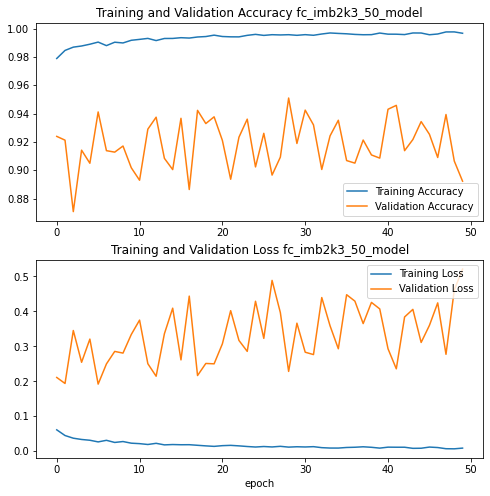

In [ ]:
show_results(fc_imb2k3_50_model_history, name='fc_imb2k3_50_model')

In [ ]:
get_correct_results(fc_imb2k3_50_model, val_dataset)

total_correct:  tf.Tensor(5788, shape=(), dtype=int32)
total_correct_pos:  tf.Tensor(5584, shape=(), dtype=int32)
total_correct_neg:  tf.Tensor(204, shape=(), dtype=int32)


# Oversample & Upsample Imbalanced Data (50%) 

## Config and Load Data

In [ ]:
TRAIN_PATH_OVER_2k3_50 = "/media/aivn24/partition2/Khoa/AI2021/imbalanced_classification/Exercise/over_data/2k3_50_augment"

In [ ]:
train_imgs_path = get_img_path_and_labels(TRAIN_PATH_OVER_2k3_50, num_pos=-1, num_neg=11500)
train_dataset = tf.data.Dataset.from_tensor_slices((train_imgs_path[0], train_imgs_path[1]))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

TOTAL SAMPLES:  23000
POSSITVE CLASS:  11500
NEGATIVE CLASS:  11500


In [ ]:
val_imgs_path = get_img_path_and_labels(VAL_PATH, num_pos=-1)
val_dataset = tf.data.Dataset.from_tensor_slices((val_imgs_path[0],val_imgs_path[1]))
val_dataset = val_dataset.map(load_image_val)
val_dataset = val_dataset.batch(BATCH_SIZE)

TOTAL SAMPLES:  11600
POSSITVE CLASS:  5800
NEGATIVE CLASS:  5800


## Build Model 

In [ ]:
ou_imb2k3_50_model = build_model(input_shape= (IMG_HEGIHT, IMG_WIDHT, IMG_CHANNEL))

## Compile and Train 

In [ ]:
base_learning_rate = 0.0001
ou_imb2k3_50_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(base_learning_rate),
              metrics=['accuracy'])

In [ ]:
ou_imb2k3_50_model_history = ou_imb2k3_50_model.fit(train_dataset,
                         epochs=50,
                         validation_data=val_dataset)

Epoch 1/50
45/45 [==============================] - 25s 515ms/step - loss: 0.5451 - accuracy: 0.7047 - val_loss: 0.8490 - val_accuracy: 0.5000
Epoch 2/50
45/45 [==============================] - 20s 444ms/step - loss: 0.3706 - accuracy: 0.8210 - val_loss: 1.5572 - val_accuracy: 0.5000
Epoch 3/50
45/45 [==============================] - 20s 443ms/step - loss: 0.2805 - accuracy: 0.8747 - val_loss: 1.5435 - val_accuracy: 0.5000
Epoch 4/50
45/45 [==============================] - 20s 443ms/step - loss: 0.2270 - accuracy: 0.9030 - val_loss: 1.0908 - val_accuracy: 0.5008
Epoch 5/50
45/45 [==============================] - 20s 444ms/step - loss: 0.1929 - accuracy: 0.9201 - val_loss: 1.1678 - val_accuracy: 0.5161
Epoch 6/50
45/45 [==============================] - 20s 442ms/step - loss: 0.1722 - accuracy: 0.9286 - val_loss: 0.6800 - val_accuracy: 0.6522
Epoch 7/50
45/45 [==============================] - 20s 445ms/step - loss: 0.1523 - accuracy: 0.9382 - val_loss: 0.8711 - val_accuracy: 0.6068

In [ ]:
ou_imb2k3_50_model.save(os.path.join(MODEL_PATH, 'ou_imb2k3_50_model.h5'))

## Evaluate Models 

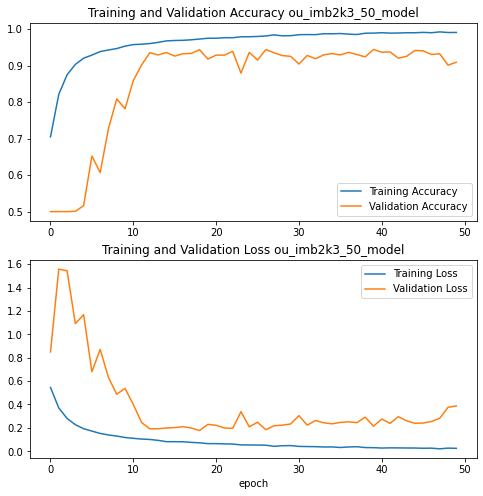

In [ ]:
show_results(ou_imb2k3_50_model_history, name='ou_imb2k3_50_model')

In [ ]:
get_correct_results(ou_imb2k3_50_model, val_dataset)

total_correct:  tf.Tensor(10542, shape=(), dtype=int32)
total_correct_pos:  tf.Tensor(4849, shape=(), dtype=int32)
total_correct_neg:  tf.Tensor(5693, shape=(), dtype=int32)
